# Introduction to B cell repertoire analysis using the Immcantation framework

![](assets/cover.png)

The field of high-throughput adaptive immune receptor repertoire sequencing (AIRR-seq) has experienced significant growth in recent years, but this growth has come with considerable complexity and variety in experimental design. These complexities, combined with the high germline and somatic diversity of immunoglobulin repertoires, present analytical challenges requiring specialized methodologies.

**This tutorial covers:**
- V(D)J gene annotation and novel polymorphism detection
- Inference of B cell clonal relationships
- Diversity analysis
- Mutational load profiling
- Modeling of somatic hypermutation (SHM) targeting
- Quantification of selection pressure

General workflow:  
![Workflow](assets/workflow_h_cmd.png)


## Resources

- You can email [immcantation@googlegroups.com](mailto:immcantation@googlegroups.com) with any questions or issues.
- Documentation: http://immcantation.org
- Source code and bug reports: https://bitbucket.org/kleinstein/
- Docker/Singularity container for this lab: https://hub.docker.com/r/immcantation/lab
- Slides and example data: https://goo.gl/FpW3Sc

## How to use the notebook

Jupyter Notebook documentation: https://jupyter-notebook.readthedocs.io/en/stable/

**Ctrl+Enter** will run the code in the selected cell and **Shift+Enter** will run the code and move to the following cell.

## Inside this container

This container comes with software, scripts, reference V(D)J germline genes and example data that is ready to use. The commands `versions report` and `builds report` show the versions and dates respectively of the tools and data.

### Software versions
Use this command to list the software versions

In [1]:
%%bash
versions report

immcantation: devel
date: 2022.04.11

presto: 0.7.0
changeo: 1.2.0
alakazam: 1.2.0
shazam: 1.1.0.999
tigger: 1.0.0.999
scoper: 1.2.0.999
dowser: 0.1.0
enchantr: 0.0.0
prestor: 0.0.7
rabhit: 0.1.5
rdi: 1.0.0
igphyml: 1.1.3

airr-py: 1.3.1
airr-r: 1.3.0
blast: 2.9.0
cd-hit: 4.8.1
igblast: 1.18.0
muscle: 3.8.425
phylip: 3.697
vsearch: 2.13.6


### Build versions
Use this command to list the date and changesets used during the image build.

In [2]:
%%bash
builds report

date: 2022-05-17 11:13:04 UTC
immcantation: 4.3.0-61-g03e1c6f03a44+
presto: 0.7.0-7-gb3ce9f8670ac
changeo: 1.2.0-7-g2cc7614f6c0a
alakazam: 1.2.0+
shazam: 1.1.0-25-g95a7cdaec293+
tigger: 6c31d6a59167+
rdi: d27b9067cab6+
scoper: 1.2.0-7-g88cc058cc11d+
prestor: 0.0.7+


### Example data used in the tutorial

`../data/input.fasta`: Processed B cell receptor reads from one healthy donor (PGP1) 3 weeks after flu vaccination (*Laserson et al. (2014)*)
- As part of the processing, each sequence has been annotated with the isotype.
- This step is not a part of the tutorial, but you can learn how to do it [here](https://presto.readthedocs.io/en/latest/examples/primers.html#assigning-isotype-annotations-from-the-constant-region-sequence).

In [3]:
%%bash
head ../data/input.fasta

>seq1|ISOTYPE=IGHM
nnnnnnnnnnnnnnnnnnnnnnnagtgtcaggtgcagctggtggagctggggagcgtggt
ccagcctgggaggccctgagtctctcctgtgcagcctctggattcaccttcagtctctat
gctatgcactgggtccgccaggctccaggcaaggggctggagtgggtggcagttatatca
tatcatgtaagcagtaaatactacgcagactccgtgaagggccgattcaccatctccaga
gacaattccaagaacacgctgtatctgcaaatgaacagcctgagagctgaggacacggct
gtgtattactgtgcgagagggccctatagtactggttattactacgagcttgactactgg
ggccagggaacgctcggtcacccgtctcctcacgggtagtgcatccgccccaaccc
>seq2|ISOTYPE=IGHM
nnnnnnnnnnnnnnnnnntgtcccaggtgcagctgcaggagtcgggcccaggactggtga


### Reference germlines

The container has human and mouse reference V(D)J germline genes from IMGT and the corresponding IgBLAST databases for these germline repertoires.

In [4]:
%%bash
ls /usr/local/share/germlines/imgt

IMGT.yaml
human
mouse
rabbit
rat
rhesus_monkey


In [5]:
%%bash
ls /usr/local/share/igblast

database
fasta
internal_data
optional_file


# V(D)J gene annotation

The first step in the analysis of processed reads (`input.fasta`) is to annotate each read with its germline V(D)J gene alleles and to identify relevant sequence structure such as the CDR3 sequence. Immcantation provides tools to read the output of many popular V(D)J assignment tools, including [IMGT/HighV-QUEST](http://www.imgt.org/HighV-QUEST) and [IgBLAST](https://www.ncbi.nlm.nih.gov/igblast/). 

Here, we will use IgBLAST. Change-O provides a wrapper script (`AssignGenes.py`) to run IgBLAST using the reference V(D)J germline sequences in the container.

##  A test with 200 sequences

It is often useful to prototype analysis pipelines using a small subset of sequences. For a quick test of Change-O's V(D)J assignment tool, use `SplitSeq.py` to extract 200 sequences from `input.fasta`, then assign the V(D)J genes with `AssignGenes.py`.

In [6]:
%%bash
# reference germlines in /usr/local/share/igblast
mkdir -p results/igblast
SplitSeq.py sample -n 200 --outdir results --fasta -s ../data/input.fasta


     START> SplitSeq
   COMMAND> sample
      FILE> input.fasta
MAX_COUNTS> 200
     FIELD> None
    VALUES> None

PROGRESS> 13:04:10 |Done                     | 0.0 min

PROGRESS> 13:04:10 |Done                     | 0.0 min

MAX_COUNT> 200
  SAMPLED> 200
   OUTPUT> input_sample1-n200.fasta

END> SplitSeq



`AssignGenes.py` performs V(D)J assignment with IgBLAST.
- It requires the input sequences (`-s`) and a reference germlines database (`-b`). In this case, we use the germline database already available in the container.
- The organism is specified with `--organism` and the type of receptor with `--loci` (`ig` for the B cell receptor).
- Use `--format blast` to specify that the results should be in the `fmt7` format.
- Improved computational speed can be achieved by specifying the number of processors with `--nproc`. 

In [7]:
%%bash
AssignGenes.py igblast -s results/input_sample1-n200.fasta \
-b /usr/local/share/igblast --organism human --loci ig \
--format blast --outdir results/igblast --nproc 8

   START> AssignGenes
 COMMAND> igblast
 VERSION> 1.18.0
    FILE> input_sample1-n200.fasta
ORGANISM> human
    LOCI> ig
   NPROC> 8

PROGRESS> 13:04:16 |Done                     | 0.1 min

  PASS> 200
OUTPUT> input_sample1-n200_igblast.fmt7
   END> AssignGenes



## V(D)J assignment using all the data

To run the command on all of the data, modify it to change the input file (`-s`) to the full data set. *Please note that this may take some time to finish running.*

In [8]:
%%bash
AssignGenes.py igblast -s ../data/input.fasta \
-b /usr/local/share/igblast --organism human --loci ig \
--format blast --outdir results/igblast --nproc 8

   START> AssignGenes
 COMMAND> igblast
 VERSION> 1.18.0
    FILE> input.fasta
ORGANISM> human
    LOCI> ig
   NPROC> 8

PROGRESS> 13:44:57 |Done                     | 40.7 min

  PASS> 91010
OUTPUT> input_igblast.fmt7
   END> AssignGenes



# Data standardization using Change-O
*Gupta NT, Vander Heiden JA, Uduman M, Gadala-Maria D, Yaari G, Kleinstein SH. Change-O: a toolkit for analyzing large-scale B cell immunoglobulin repertoire sequencing data. Bioinformatics 2015; doi: [10.1093/bioinformatics/btv359](10.1093/bioinformatics/btv359)*

Once the V(D)J annotation is finished, the IgBLAST results are parsed into a [standardized format](https://changeo.readthedocs.io/en/stable/standard.html) suitable for downstream analysis. All tools in the Immcantation framework use this format, which allows for interoperability and provides flexibility when designing complex workflows.

In this example analysis, the `fmt7` results from IgBLAST are converted into the [AIRR](https://docs.airr-community.org/en/latest/datarep/rearrangements.html) format, a tabulated text file with one sequence per row. Columns provide the annotation for each sequence using standard column names as described here: https://docs.airr-community.org/en/latest/datarep/rearrangements.html.

## Generate a standardized database file
The command line tool `MakeDb.py igblast` requires the original input sequence fasta file (`-s`) that was passed to the V(D)J annotation tool, as well as the V(D)J annotation results (`-i`). The argument `--format airr` specifies that the results should be converted into the AIRR format. The path to the reference germlines is provided by `-r`.

In [9]:
%%bash
mkdir -p results/changeo
MakeDb.py igblast \
-s ../data/input.fasta -i results/igblast/input_igblast.fmt7 \
--format airr \
-r /usr/local/share/germlines/imgt/human/vdj/ --outdir results/changeo \
--outname data

         START> MakeDB
       COMMAND> igblast
  ALIGNER_FILE> input_igblast.fmt7
      SEQ_FILE> input.fasta
       ASIS_ID> False
    ASIS_CALLS> False
       PARTIAL> False
      EXTENDED> False
INFER_JUNCTION> False

PROGRESS> 13:45:00 |Done                | 0.0 min

PROGRESS> 13:46:35 |####################| 100% (91,010) 1.6 min

OUTPUT> data_db-pass.tsv
  PASS> 87509
  FAIL> 3501
   END> MakeDb



## Subset the data to include productive heavy chain sequences

We next filter the data from the previous step to include **only productive** sequences from the heavy chain. The determination of whether a sequence is productive (or not) is provided by the V(D)J annotation software.

`ParseDb.py select` finds the rows in the file `-d` for which the column `productive` (specified with `-f`) contains the values `T` or `TRUE` (specified by `-u`). The prefix `data_p` will be used in the name of the output file (specified by `--outname`).

In [10]:
%%bash
ParseDb.py select -d results/changeo/data_db-pass.tsv \
-f productive -u T --outname data_p

  START> ParseDb
COMMAND> select
   FILE> data_db-pass.tsv
 FIELDS> productive
 VALUES> T
  REGEX> False

PROGRESS> 13:46:43 |####################| 100% (87,509) 0.1 min

   OUTPUT> data_p_parse-select.tsv
  RECORDS> 87509
 SELECTED> 64896
DISCARDED> 22613
      END> ParseDb



Next, we filter the data to include **only heavy chain** sequences. 

`ParseDb.py select` finds the rows in the file `-d` from the previous step for which the column `v_call` (specified with `-f`) contains (pattern matching specified by `--regex`) the word `IGHV` (specified by `-u`). The prefix `data_ph` (standing for productive and heavy) will be used in the name of the output file (specified by `--outname`) to indicate that this file contains productive (p) heavy (h) chain sequence data.

In [11]:
%%bash
ParseDb.py select -d results/changeo/data_p_parse-select.tsv \
-f v_call -u IGHV --regex --outname data_ph

  START> ParseDb
COMMAND> select
   FILE> data_p_parse-select.tsv
 FIELDS> v_call
 VALUES> IGHV
  REGEX> True

PROGRESS> 13:46:52 |####################| 100% (64,896) 0.1 min

   OUTPUT> data_ph_parse-select.tsv
  RECORDS> 64896
 SELECTED> 64896
DISCARDED> 0
      END> ParseDb



# Set up the notebook to run R code
The following steps in the tutorial will use several R packages in the Immcantation framework. The next two lines of code are required to be able to use `R magic` and run `R` code in this Jupyter notebook.

In [12]:
# R for Python
import rpy2.rinterface
%load_ext rpy2.ipython

# Genotyping and discovery of novel V gene alleles with TIgGER

*Gadala-Maria D, Yaari G, Uduman M, Kleinstein S (2015). “Automated analysis of high-throughput B cell sequencing data reveals a high frequency of novel immunoglobulin V gene segment alleles.” Proceedings of the National Academy of Sciency of the United States of America, E862-70.*

*Gadala-Maria D, et al. (2019). “Identification of subject-specific immunoglobulin alleles from expressed repertoire sequencing data.” Frontiers in Immunology.*

V(D)J assignment is a key step in analyzing repertoires and is done by matching the sequences against a database of known V(D)J alleles. However, current databases are incomplete and this process will fail for sequences that utilize previously undetected alleles. Some assignments may also occur to genes which are not carried by the individual. The TIgGER R package infers subject-specific V genotypes (including novel alleles), then uses the results to improve the V gene annotations. 

## Load libraries and read in the data
After loading the libraries needed, the process is started by using `readChangeoDb` to read the tabulated data generated in the previous step.

In [13]:
%%R

suppressPackageStartupMessages(library(airr))
suppressPackageStartupMessages(library(alakazam))
suppressPackageStartupMessages(library(dplyr))
suppressPackageStartupMessages(library(ggplot2))
suppressPackageStartupMessages(library(tigger))

dir.create(file.path("results","tigger"))
db <- read_rearrangement(file.path("results","changeo","data_ph_parse-select.tsv"))
colnames(db) # show the column names in the database

 [1] "sequence_id"        "sequence"           "rev_comp"          
 [4] "productive"         "v_call"             "d_call"            
 [7] "j_call"             "sequence_alignment" "germline_alignment"
[10] "junction"           "junction_aa"        "v_cigar"           
[13] "d_cigar"            "j_cigar"            "stop_codon"        
[16] "vj_in_frame"        "locus"              "junction_length"   
[19] "np1_length"         "np2_length"         "v_sequence_start"  
[22] "v_sequence_end"     "v_germline_start"   "v_germline_end"    
[25] "d_sequence_start"   "d_sequence_end"     "d_germline_start"  
[28] "d_germline_end"     "j_sequence_start"   "j_sequence_end"    
[31] "j_germline_start"   "j_germline_end"     "isotype"           


`readIgFasta` loads the reference V germline genes that were used in the V(D)J assignment (in this case the sequences in the Immcantation container).

In [14]:
%%R
ighv <- readIgFasta(file.path("","usr","local","share","germlines","imgt","human","vdj","imgt_human_IGHV.fasta"))
ighv[1] # show the first germline

                                                                                                                                                                                                                                                                                                                       IGHV1-18*01 
"CAGGTTCAGCTGGTGCAGTCTGGAGCT...GAGGTGAAGAAGCCTGGGGCCTCAGTGAAGGTCTCCTGCAAGGCTTCTGGTTACACCTTT............ACCAGCTATGGTATCAGCTGGGTGCGACAGGCCCCTGGACAAGGGCTTGAGTGGATGGGATGGATCAGCGCTTAC......AATGGTAACACAAACTATGCACAGAAGCTCCAG...GGCAGAGTCACCATGACCACAGACACATCCACGAGCACAGCCTACATGGAGCTGAGGAGCCTGAGATCTGACGACACGGCCGTGTATTACTGTGCGAGAGA" 


## Identify potentially novel V gene alleles

For each V gene allele, `findNovelAlleles` analyzes the sequences that were assigned the allele and evaluates the apparent mutation frequency at each position as a function of sequence-wide mutation counts. Positions that contain polymorphisms (rather than somatic hypermutations) will exhibit a high apparent mutation frequency even when the sequence-wide mutation count is low. 

In this example, TIgGER finds one novel V gene allele.

In [15]:
%%R
nv <- findNovelAlleles(db, germline_db = ighv, nproc = 8) # find novel alleles

In [16]:
%%R
selectNovel(nv) # show novel alleles

  germline_call                note polymorphism_call nt_substitutions
1   IGHV3-20*01 Novel allele found! IGHV3-20*01_C307T           307C>T
2   IGHV3-20*03 Novel allele found!  IGHV3-20*03_T68G            68T>G
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            novel_imgt
1                                                                                                                                                                                                           

The function `plotNovel` helps visualize the supporting evidence for calling the novel V gene allele. The mutation frequency of the position that is predicted to contain a polymorphism is highlighted in red. In this case, the position contains a high number of apparent mutations for all sequence-wide mutation counts (top panel). 

By default, `findNovelAlleles` uses several additional filters to avoid false positive allele calls. For example, to avoid calling novel alleles resulting from clonally-related sequences, TIgGER requires that sequences perfectly matching the potential novel allele be found in sequences with a diverse set of J genes and a range of junction lengths. This can be observed in the bottom panel.

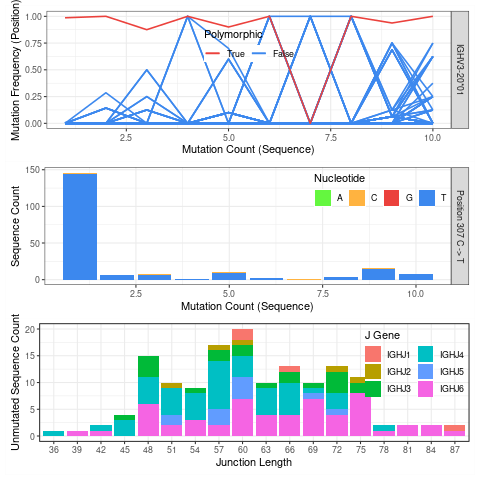

In [17]:
%%R
plotNovel(db, selectNovel(nv)[1,]) # visualize the novel allele(s)

## Genotyping, including novel V gene alleles

The next step is to infer the subject’s genotype and use this to improve the V gene calls. 

`inferGenotype` uses a frequency-based method to determine the genotype. For each V gene, it finds the minimum set of alleles that can explain a specified fraction of each gene’s calls. The most commonly observed allele of each gene is included in the genotype first, then the next most common allele is added until the desired fraction of sequence annotations can be explained. 

Immcantation also includes other methods for inferring subject-specific genotypes (`inferGenotypeBayesian`).

In [18]:
%%R
gt <- inferGenotype(db, germline_db = ighv, novel = nv)

# save genotype inf .fasta format to be used later with CreateGermlines.py
gtseq <- genotypeFasta(gt, ighv, nv)
writeFasta(gtseq, file.path("results","tigger","v_genotype.fasta"))

gt %>% arrange(total) %>% slice(1:3) # show the first 3 rows

      gene alleles counts total note
1  IGHV2-5   02,01  58,48   106     
2 IGHV3-49   04,05  77,39   116     
3 IGHV3-11   01,04  85,53   138     


The individual's genotype can be visualized with `plotGenotype`. Each row is a gene, with colored cells indicating each of the alleles for that gene that are included in the inferred genotype.

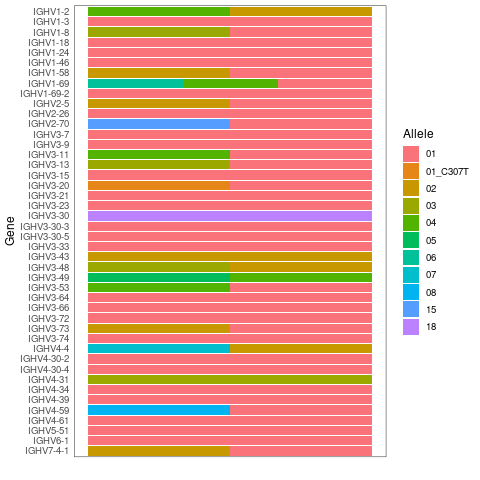

In [19]:
%%R
plotGenotype(gt) # genotyping including novel V gene alleles

## Reassign V gene allele annotations

Some of the V gene calls may use genes that are not part of the subject-specific genotype inferred by TIgGER. These gene calls can be corrected with `reassignAlleles`. Mistaken allele calls can arise, for example, from sequences which by chance have been mutated to look like another allele. `reassignAlleles` saves the corrected calls in a new column, `v_call_genotyped`. 

With `write_airr` the updated data is saved as a tabulated file for use in the following steps.

In [20]:
%%R
db <- reassignAlleles(db, gtseq)

# show some of the corrected gene calls
db %>% filter(v_call != v_call_genotyped) %>% sample_n(3) %>% select(v_call, v_call_genotyped)

# A tibble: 3 × 2
  v_call                               v_call_genotyped        
  <chr>                                <chr>                   
1 IGHV4-34*01,IGHV4-34*04              IGHV4-34*01             
2 IGHV3-7*01,IGHV3-7*03                IGHV3-7*01              
3 IGHV3-23*01,IGHV3-23*04,IGHV3-23D*01 IGHV3-23*01,IGHV3-23D*01


In [21]:
%%R
write_airr(db, file.path("results","tigger","data_ph_genotyped.tsv"))

# Clonal diversity analysis

**Goal:** Partition (cluster) sequences into clonally related lineages. Each lineage is a group of sequences that came from the same original naive cell.

Summary of the key steps:
- *Determine clonal clustering threshold:* sequences which are under this cut-off are clonally related.
- *Assign clonal groups:* add an annotation (`clone_id`) that can be used to identify a group of sequences that came from the same original naive cell.
- *Reconstruct germline sequences:* figure out the germline sequence of the common ancestor, before mutations are introduced during clonal expansion and SMH.
- *Analize clonal diversity:* number and size of clones? any expanded clones?


![](assets/clonalexpansion.png)

## Clonal assignment using the CDR3 as a fingerprint

*Gupta et al. (2017)*

*Nouri and Steven H Kleinstein (2018b)*

Clonal relationships can be inferred from sequencing data. Hierarchical clustering is a widely used method for identify clonally related sequences. This method requires a measure of distance between pairs of sequences and a choice of linkage to define the distance between groups of sequences. Since the result will be a tree, a threshold to cut the hierarchy into discrete clonal groups is also needed. 

The figure below on the left shows a tree and the chosen threshold (red dotted line). Sequences which have a distance under this threshold are considered to be part of the same clone (i.e., clonally-related) whereas sequences which have distance above this threshold are considered to be part of independent clones (i.e., not clonally related). 

`shazam` provides methods to calculate the distance between sequences and find an appropriate distance threshold for each dataset (`distToNearest` and `findThreshold`). The threshold can be determined by analyzing the distance to the nearest distribution. This is the set of distances between each sequence and its closest non-identical neighbour. 

The figure below on the right shows the distance-to-nearest distribution for a repertoire. Typically, the distribution is bimodal. The first mode (on the left) represents sequences that have at least one clonal relative in the dataset, while the second mode (on the right) is representative of the sequences that do not have any clonal relatives in the data (sometimes called "singletons"). A reasonable threshold will separate these two modes of the distribution. In this case, it is easy to manually determine a threshold as a value intermediate between the two modes. However, `findThreshold` can be used to automatically find the threshold.

<img src="assets/hclust.png" width="35%" align="left"><img src="assets/distNearest.png" width="30%" align="left">

## Setting the clonal distance threshold with SHazaM

*Gupta et al. (2015)*

We first split sequences into groups that share the same V and J gene assignments and that have the same junction (or equivalently CDR3) length. This is based on the assumption that members of a clone will share all of these properties. `distToNearest` performs this grouping step, then counts the number of mismatches in the junction region between all pairs of sequences in eaach group and returns the smallest non-zero value for each sequence. At the end of this step, a new column (`dist_nearest`) which contains the distances to the closest non-identical sequence in each group will be added to `db`.

`findThreshold` uses the distribution of distances calculated in the previous step to determine an appropriate threshold for the dataset. This can be done using either a `density` or `mixture` based method. The function `plot` can be used to visualize the distance-to-nearest distribution and the threshold.

In [22]:
%%R -o thr

# get the distance to nearest neighbors
suppressPackageStartupMessages(library(shazam))
db <- distToNearest(db, model = "ham", normalize = "len", vCallColumn = "v_call_genotyped", nproc = 4)

# determine the threshold
threshold <- findThreshold(db$dist_nearest, method = "density")
thr <- round(threshold@threshold, 2)
thr

[1] 0.12


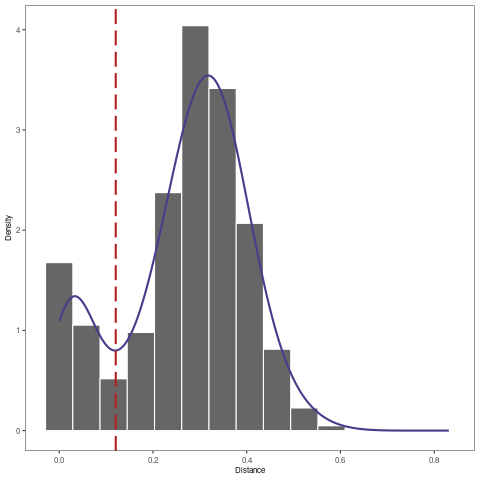

In [23]:
%%R
plot(threshold) # plot the distribution

### Advanced method: Spectral-based clonal clustering (SCOPer)

*Nouri and Steven H Kleinstein (2018a)*

In some datasets, the distance-to-nearest distribution may not be bimodal and `findThreshold` may fail to determine the distance threshold. In these cases, spectral clustering with an adaptive threshold to determine the local sequence neighborhood may be used. This can be done with functions from the [SCOPer R package](https://scoper.readthedocs.io/).

## Change-O: Clonal assignment

Once a threshold is decided, the command line tool `DefineClones.py` from Change-O performs the clonal assignment. There are some arguments that need to be specified:
- `--model`: the distance metric used in `distToNearest`
- `--norm`: type of normalization used in `distToNearest`
- `--dist`: the cut-off from `findThreshold`

At the end of this step, the output file will have an additional column (`clone_id`) that provides an identifier for each sequence to indicate which clone it belongs to (i.e., sequences that have the same identifier are clonally-related). *Note that these identifiers are only unique to the dataset used to carry out the clonal assignments.*

In [24]:
# assign clonal groups
! DefineClones.py -d results/tigger/data_ph_genotyped.tsv --vf v_call_genotyped \
--model ham --norm len --dist {thr[0]} --format airr --nproc 8 \
--outname data_ph_genotyped --outdir results/changeo/

       START> DefineClones
        FILE> data_ph_genotyped.tsv
   SEQ_FIELD> junction
     V_FIELD> v_call_genotyped
     J_FIELD> j_call
 MAX_MISSING> 0
GROUP_FIELDS> None
      ACTION> set
        MODE> gene
    DISTANCE> 0.12
     LINKAGE> single
       MODEL> ham
        NORM> len
         SYM> avg
       NPROC> 8

PROGRESS> [Grouping sequences] 13:51:47 (64896) 1.4 min

PROGRESS> [Assigning clones] 13:59:39 |####################| 100% (64,896) 9.2 min

 OUTPUT> data_ph_genotyped_clone-pass.tsv
 CLONES> 34471
RECORDS> 64896
   PASS> 64845
   FAIL> 51
    END> DefineClones



## Change-O: add full length germline sequences

The next step is to identify the V(D)J germline sequences from which each of the observed sequences is derived. These germlines will be used in downstream analysis to infer somatic mutations and reconstruct lineages. `CreatGermlines.py` takes the alignment information in the Change-O file (`-d`) as well as the reference database used by the alignment software (`-r`) and generates a germline sequence for each individual observed sequence. 

If the argument `--cloned` is used, the function assigns the same germline to all sequences belonging to the same clone. `-g` is used to specify the type of germlines to be reconstructed. In this example, `-g dmask` is used to mask the D region, meaning that all nucleotides in the  N/P and D-segments are replaced with N's. This is often done because the germline base calls from this region are unreliable for B cell receptor alignments. 

At the end of this step, the data file will have the germline sequence in the `germline_alignment_d_mask` column.

In [25]:
%%bash
CreateGermlines.py -d results/changeo/data_ph_genotyped_clone-pass.tsv \
-r /usr/local/share/germlines/imgt/human/vdj/*IGH[DJ].fasta results/tigger/v_genotype.fasta \
-g dmask --cloned --vf v_call_genotyped \
--format airr --outname data_ph_genotyped

      START> CreateGermlines
       FILE> data_ph_genotyped_clone-pass.tsv
 GERM_TYPES> dmask
  SEQ_FIELD> sequence_alignment
    V_FIELD> v_call_genotyped
    D_FIELD> d_call
    J_FIELD> j_call
     CLONED> True
CLONE_FIELD> clone_id

PROGRESS> 14:00:01 |Done                | 0.2 min

PROGRESS> 14:00:20 |####################| 100% (64,845) 0.3 min

 OUTPUT> data_ph_genotyped_germ-pass.tsv
RECORDS> 64845
   PASS> 64841
   FAIL> 4
    END> CreateGermlines



## Alakazam: Analysis of clonal diversity

*Gupta et al. (2015)*

Once the database is annotated with clonal relationships (`clone_id`), the R package `alakazam` is used to analyze clonal diversity and abundance.

### Load data and subset to IGHM, IGHG and IGHA

The tab-delimited file is loaded with the function `read_rearrangement`. In this example, the analysis will focus separately on sequences with different isotypes. 
- The isotype for each sequences (IGHM, IGHG or IGHA) is in the `isotype` column.  
- The function `subset` is used to keep only those sequences as part of the analysis.

In [26]:
%%R
# update names in alakazam’s default colors (IG_COLORS)
names(IG_COLORS) <- c( "IGHA", "IGHD", "IGHE", "IGHG", "IGHM","IGHK", "IGHL")

# read in the file that passed cloning and germline creation
db <- read_rearrangement(file.path("results", "changeo", "data_ph_genotyped_germ-pass.tsv"))

# subset data to IgA, IgG and IgM
db <- subset(db, isotype %in% c("IGHA", "IGHG", "IGHM"))

### Clonal abundance

Clonal abundance is the size of each clone (as a fraction of the entire repertoire). `estimateAbundance` estimates the clonal abundance distribution along with confidence intervals on these clone sizes using bootstrapping. 

In this example, the abundance is analyzed by isotype (`group = "isotype"`). In the figure below, the y-axis shows the clone abundance (i.e., the size as a percent of the repertoire) and the x-axis is a rank of each clone, where the rank is sorted by size from larger (rank 1, left) to smaller (right). The shaded areas are confidence intervals. 

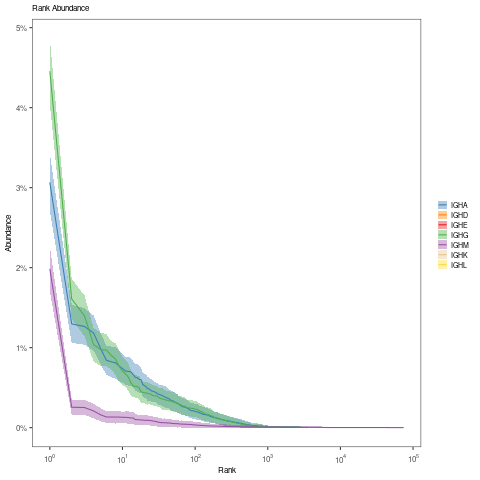

In [27]:
%%R
# calculate the rank-abundance curve
a <- estimateAbundance(db, group = "isotype")
plot(a, colors = IG_COLORS)

### Clonal diversity

The clonal abundance distribution can be characterized using diversity statistics. Diversity scores (`D`) are calculated using the generalized diversity index (Hill numbers), which covers many different measures of diversity in a single function with a single varying parameter, the diversity order `q`.

The function `alphaDiversity` resamples the sequences and calculates diversity scores (`D`) over a interval of diversity orders (`q`). The diversity (`D`) is shown on the y-axis and the x-axis is the parameter `q`. 
- `q = 0` corresponds to Species Richness
- `q = 1` corresponds to Shannon Entropy
- `q = 2` corresponds to Simpson Index

Inspection of this figure is useful to determine whether any difference in diversity between two repertoires depends on the statistic used or if it is a universal property. For example, you can see that the blue curve is changing when you change `q`, whereas the  diversity of the green and red curves doesn't change significantly along values of `q`. 

|======================================================|100% ~0 s remaining     

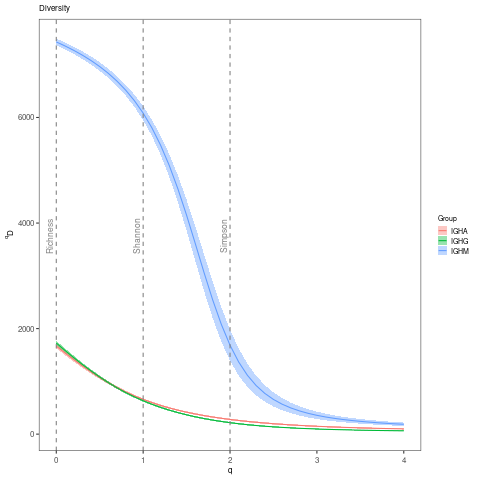

In [28]:
%%R
# generate the Hill diversity curve
d <- alphaDiversity(db, group = "isotype")
p <- plot(d, silent = T)
p + geom_vline(xintercept = c(0,1,2), color = "grey50", linetype = "dashed") + 
    geom_text(data = data.frame(q = c(0,1,2), y = round(max(p$data$d_upper)/2), 
              label = c("Richness", "Shannon", "Simpson")), 
              aes(x = q, y = y,label = label), size = 3, angle = 90, vjust = -0.4, inherit.aes  =  F, color = "grey50")

# Alakazam: Physicochemical properties of the CDR3

CDR3 is the most variable region of the antibody sequence and its physicochemical properties are key contributors to antigen specificity. The function `aminoAcidProperties` in the `alakazam` R package can calculate several amino acid sequence physicochemical properties such as length, hydrophobicity (GRAVY index), bulkiness, polarity and net charge, among others. To obtain the CDR3, the junction sequence (specified by `seq = "junction"`), which is available in the form of a nucleotide sequence (`nt = T`), is trimmed to remove the first and last codon/amino acids before calculating the properties.

The figure below, generated with standard `ggplot` commands, shows the distribution of the CDR3 amino acid length by isotype.

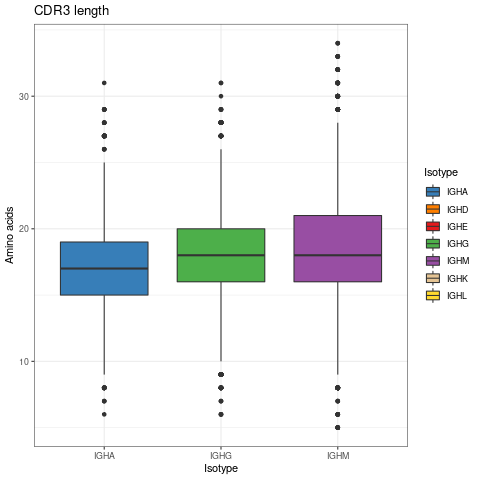

In [29]:
%%R
# calculate CDR3 amino acid properties
db <- aminoAcidProperties(db, seq = "junction", nt = T, trim = T, label = "cdr3")
# Plot
ggplot(db, aes(x = isotype, y = cdr3_aa_length)) + theme_bw() +
  ggtitle("CDR3 length") + xlab("Isotype") + ylab("Amino acids") +
  scale_fill_manual(name = "Isotype", values = IG_COLORS) +
  geom_boxplot(aes(fill = isotype))

# Alakazam: family, gene and allele usage

The study of biases in gene usage is also of interest. The function `countGenes` from the `alakazam` R packages can determine the count and relative abundance of V, D and J at the level of alleles, genes, or families.

## V family usage by isotype

Here, `countGenes` counts V gene family usage (`mode = "family"`) by isotype (`groups = "isotype"`) using the V gene allele calls in the column `v_call_genotyped`. `--clone` specifies each clone will be considered only once, with the most common gene within the clone being used.

In [30]:
%%R
# V family usage by isotype
# "clone" specifies to consider one gene per clone_id,
# the most common gene within each clone
usage_fam_iso <- countGenes(db, gene = "v_call_genotyped", groups = "isotype", clone = "clone_id", mode = "family")
# groups = "isotype", then usage by isotype sums 1
usage_fam_iso %>% group_by(isotype) %>% summarize(total = sum(clone_freq))

# A tibble: 3 × 2
  isotype total
  <chr>   <dbl>
1 IGHA        1
2 IGHG        1
3 IGHM        1


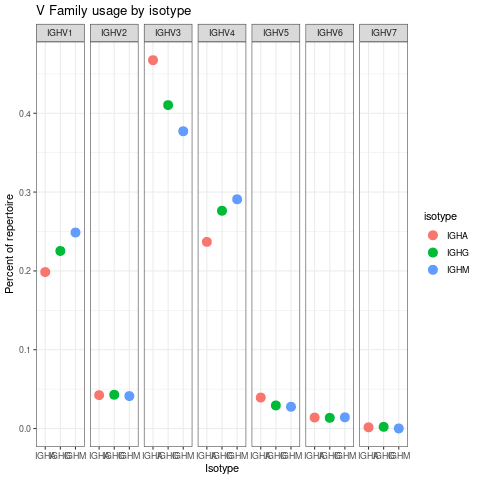

In [31]:
%%R
ggplot(usage_fam_iso, aes(x = isotype, y = clone_freq)) + 
geom_point(aes(color = isotype), size = 4) +
scale_fill_manual(name = "Isotype", values = IG_COLORS) + 
facet_wrap(~gene, nrow = 1) +
theme_bw() + ggtitle("V Family usage by isotype") +
ylab("Percent of repertoire") + xlab("Isotype")


# Alakazam: lineage reconstruction

Hoehn et al. (2019)

B cell repertoires often consist of hundreds to thousands of separate clones. A clonal lineage recapitulates the ancestor-descendant relationships between clonally-related B cells and uncovering these relationships can provide insights into affinity maturation. The R package `alakazam` uses PHYLIP to reconstruct lineages following a maximum parsimony technique. PHYLIP is already installed in the Immcantation container.

Before performing lineage reconstruction, some preprocessing in needed. The code below shows an example of such preprocessing done for one of the largest clones in the example dataset. The function `makeChangeoClone` takes as input a data.frame with information for a clone (`db_clone`). `text_fields = "isotype"` specifies that annotation in the column `isotype` should be merged during duplicate removal. For example, if two duplicate sequences (defined by identical nucleotide composition) are found, and one is annotated as IGHM and the second one is an IGHG, then they will be "collapsed" into a single sequence that will have the `isotype` value "IGHM,IGHG". The preprocessing done by `makeChangeoClone` also includes masking gap positions and masking ragged ends.

In [32]:
%%R
# Select one clone, the 2nd largest, just as an example
largest_clone <- countClones(db) %>% slice(2) %>% select(clone_id) %>% as.character()
# Subset db, get db with data for largest_clone
db_clone <- subset(db, clone_id == largest_clone)
# Build tree from a single clone
x <- makeChangeoClone(db_clone, v_call = "v_call_genotyped", text_fields = "isotype")

Lineage reconstruction is done with `buildPhylipLineage`. This function uses the `dnapars` tool from PHYLIP, which in the container is located at `/usr/local/bin/dnapars`, to build the lineage, and returns an `igraph` object. This object can be quickly visualized with the command `plot`. It is possible to use `igraph` or other tools to resize nodes (e.g., by the underlying sequence count) or add colors (e.g., to indicate tissue location of B cell subsets) to help answer specific biological questions.

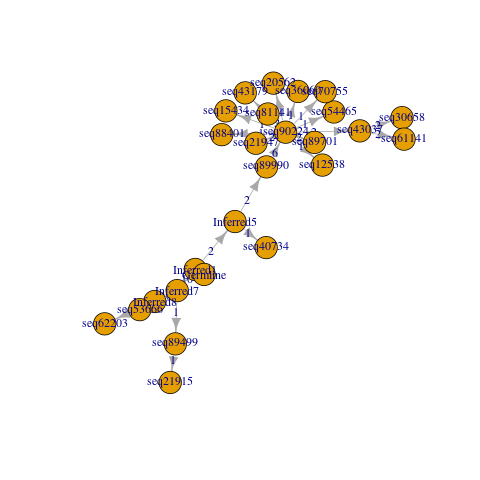

In [33]:
%%R
# Lineage reconstruction
g <- buildPhylipLineage(x, phylip_exec = "/usr/local/bin/dnapars")
suppressPackageStartupMessages(library(igraph))
plot(g)

# Alakazam: lineage topology analysis

`alakazam` has several functions to analyze the reconstructed lineage. `getMRCA` retrieves the first non-root node of a lineage tree, which is the Most Recent Common Ancestor (MRCA) for all the sequences in the clone. `getpathlength` calculates all the path lengths (in terms of the number of point mutations) from the tree root to all individual sequences. `summarizeSubtrees` calculates summary statistics for each node of a tree (node name, name of the parent node, number of edges leading from the node, total number of nodes within the subtree rooted at the node...). `tableEdges` creates a table of the total number of connections (edges) for each unique pair of annotations within a tree over all nodes.

In [34]:
%%R
# Retrieve the most ancestral sequence
getMRCA(g, root="Germline")

               name
Inferred1 Inferred1
                                                                                                                                                                                                                                                                                                                                                                                                                    sequence
Inferred1 GAGGTGCAGCTGGTGGACTCTGGGGGANNNGGCTTGGTCCAGCCTGGGGGGTCCCTGAGTCTCTCCTGTGAAGCCTCTGGATTCACCTTTNNNNNNNNNNNNAGTAACTATTGGATGACCTGGGTCCGCCAGGCTCCAGGGAAGAGGCTGGAGTTGGTGGCCAACATAAGGCATGATNNNNNNGGAAGTGAGACAAACTATGTGGACTCTGTGAAGNNNGGCCGATTCACCATCTCCAGAGACAACGCCAAGAACTCACTATATTTGCAAATGAACAGCCTTAGAGCCGAGGACACGGCAGTATATTATTGTGCGAAGCATAGAACTAGCCGCTATACATCGGGACATAATTACGSATACATGGACCTCTGGGGCAAAGGGACCACGGTCATCGTCTCCTCA
          isotype collapse_count     label steps distance
Inferred1    <NA>             NA Inferred1     1       22


In [35]:
%%R
# Calculate distance from germline
getPathLengths(g, root="Germline") %>% top_n(2)

Selecting by distance
      name steps distance
1 seq53666     4       51
2 seq62203     4       43


In [36]:
%%R
# Calculate subtree properties
summarizeSubtrees(g, fields="isotype") %>% top_n(2)

Selecting by pathlength_norm
       name isotype   parent outdegree size depth pathlength outdegree_norm
1 Inferred1    <NA> Germline         2   25     6         29           0.08
2  Germline    <NA>     <NA>         1   26     7         51           0.04
  size_norm depth_norm pathlength_norm
1 0.9615385  0.8571429       0.5686275
2 1.0000000  1.0000000       1.0000000


In [37]:
%%R
# Tabulate isotype edge relationships
tableEdges(g, "isotype", exclude=c("Germline", NA))

# A tibble: 3 × 3
# Groups:   parent [2]
  parent    child     count
  <chr>     <chr>     <int>
1 IGHA,IGHG IGHG         12
2 IGHG      IGHA,IGHG     1
3 IGHG      IGHG          3


# SHazaM: mutational load

B cell repertoires differ in the number of mutations introduced during somatic hypermutation (SHM). The `shazam` R package provides a wide array of methods focused on the analysis of SHM, including the reconstruction of SHM targeting models and quantification of selection pressure.

Having identified the germline sequence (`germline_alignment_d_mask`) in previous steps, we first identify the set of somatic hypermutations by comparing the observed sequence (`sequence_alignment`) to the germline sequence. `observedMutations` is next used to quantify the mutational load of each sequence using either absolute counts (`frequency=F`) or as a frequency (the number of mutations divided by the number of informative positions (`frequency=T`). Each mutation can be defined as either a replacement mutation (R, or non-synonymous mutation, which changes the amino acid sequence) or a silent mutation (S, or synonymous mutation, which does not change the amino acid sequence). R and S mutations can be counted together (`conmbine=T`) or independently (`combine=F`). Counting can be limited to mutations occurring within a particular region of the sequence (for example, to focus on the V region `regionDefinition=IMGT_V`) or use the whole sequence (`regionDefinition=NULL`).

Standard `ggplot` commands can be used to generate boxplots to visualize the distribution of mutation counts across sequences, which are found in the column `mu_count` that `observedMutations` added to `db`.

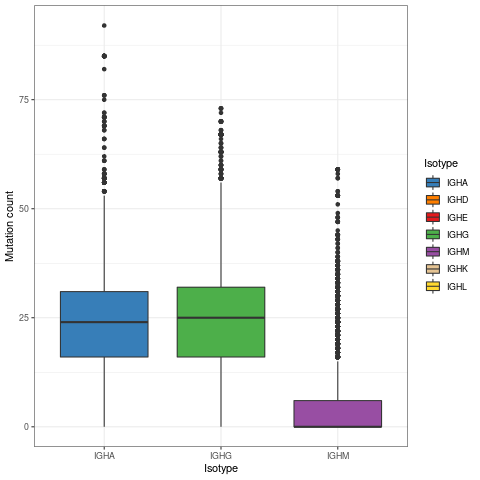

In [38]:
%%R
# Calculate total mutation count, R and S combined
db <- observedMutations(db,
            sequenceColumn="sequence_alignment", 
            germlineColumn="germline_alignment_d_mask",
            regionDefinition=NULL, frequency=F, combine = T, nproc=4)
ggplot(db, aes(x=isotype, y=mu_count, fill=isotype)) +
geom_boxplot() +
scale_fill_manual(name="Isotype",values=IG_COLORS) +
xlab("Isotype") + ylab("Mutation count") + theme_bw()

# SHazaM: models of SHM targeting biases
Yaari et al. (2013)

SHM is a stochastic process, but does not occur uniformly across the V(D)J sequence. Some nucleotide motifs (i.e., hot-spots) are targeted more frequently than others (i.e., cold-spots). These intrinsic biases are modeled using 5-mer nucleotide motifs. For each 5-mer (e.g., ATCTA), a SHM mutability model provides the relative likelihood for the center base (e.g., the C in ATCTA) to be mutated. As associated substitution model provides the relative probabilities of the center base in a 5-mer mutating to each of the other 3 bases. There are several pre-built SHM targeting models included in `shazam` which have been constructed based on experimental datasets. These include models for human and mouse, and for both light and heavy chains. In addition, `shazam` provides the `createTargetingModel` method to generate new SHM targeting models from user-supplied sequencing data.
![](assets/5mer.png)
The resulting model can be visualized as a hedgehog plot with `plotMutability`. In this visualization, 5-mers that belong to classically-defined SHM hot-spot motifs (e.g., WRC) are shown in red and green, cold-spot motifs in blue, and other motifs (i.e., neutral) in grey. The bars radiating outward are the relative mutabilities of each 5-mer. The middle circle is the central nucleotide being targeted for SHM, here shown by a green circle on the left plot (nucleotide A) and an orange circle on the right plot (nucleotide C). Moving from the center of the circle outward covers the 5-mer nucleotide motif (5' to 3'). As expected, higher relative mutation rates are observed at hot-spot motifs.

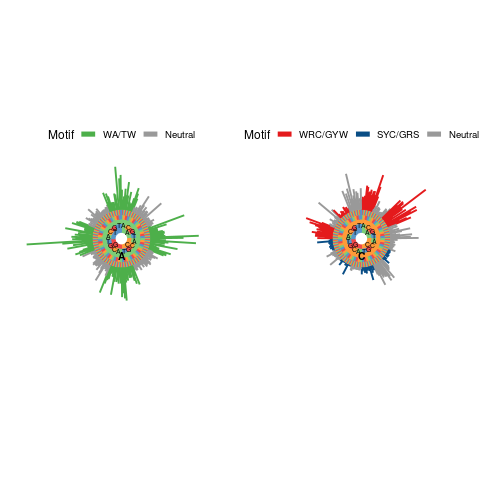

In [39]:
%%R
# Build and plot SHM targeting model
m <- createTargetingModel(db, vCallColumn="v_call_genotyped")
# nucleotides: center nucleotide characters to plot
plotMutability(m, nucleotides=c("A","C"), size=1.2)

# SHazaM: quantification of selection pressure

Yaari et al. (2012)

During T-cell dependent adaptive immune responses, B cells undergo cycles of SHM and affinity-dependent selection that leads to the accumulatation of mutations that improve their ability to bind antigens. The ability to estimate selection pressure from sequence data is of interest to understand the events driving physiological and pathological immune responses. `shazam` incorporates the Bayesian estimation of Antigen-driven SELectIoN (BASELINe) framework, to detect and quantify selection pressure, based on the analysis of somatic hypermutation patterns. Briefly, `calcBaseline` analyzes the observed frequency of replacement and silent mutations normalized by their expectated frequency based on a targeting model, and generates a probability density function (PDF) for the selection strength ($\sum$). This PDF can be used to statistically test for the occurrence of selection, as well as compare selection strength across conditions. An increased frequency of R mutations ($\sum>0$) suggests positive selection, and a decreased frequency of R mutations ($\sum<0$) points towards negative selection .
<br><br>
<div style="float:left; margin-right:2em">
    
$\sum \equiv log  \frac{\pi/(1-\pi)}{\hat{\pi}/(1-\hat{\pi})}$ 
</div>
<div>
positive Σ: Replacement frequency higher than expected

negative Σ: Replacement frequency lower than expected
</div>

The somatic hypermutations that are observed in clonally-related sequences are not independent events. In order to generate a set of independent SHM events, selection pressure analysis starts by collapsing each clone to one representative sequence (with its associated germline) using the function `collapseClones`. Next `calcBaseline` takes each representative sequences and calculates the selection pressure. The analysis can be focused on a particular region, the V region (`regionDefinition=IMGT_V`) in the example below. Because selection pressure may act differently across the BCR, we may also be interested to evaluate the selection strength for different regions such as the Complementary Determining Regions (CDR) or Framework Regions (FWR) separately. Selection strength can also be calculated separately for different isotopes or subjects. This can be done with `groupbaseline`, which convolves the PDFs from individual sequences into a single PDF representing the group of sequences (e.g., all IgG sequences). 


These PDF can be visualized with `plot`. FWR are critical to maintenance the overall structure of the BCR and typically have a lower observed selection strength, because mutations that alter the amino acid sequence are often negatively selected. CDRs are the areas of the BCR that generally bind to the antigen and may be subject to increased selection strength, although this can depend on the point in affinity maturation when the sequence is observed. In the example, negative selection is observed in the FWR, and almost no selection is observed in the CDR. In both CDR and FWR, sequences annotated with IGHM isotype show more positive selection strength than sequences annotated with IGHG and IGHA.

R[write to console]: calcBaseline will calculate observed and expected mutations for clonal_sequence using clonal_germline as a reference.



Calculating BASELINe probability density functions...
Grouping BASELINe probability density functions...
Calculating BASELINe statistics...


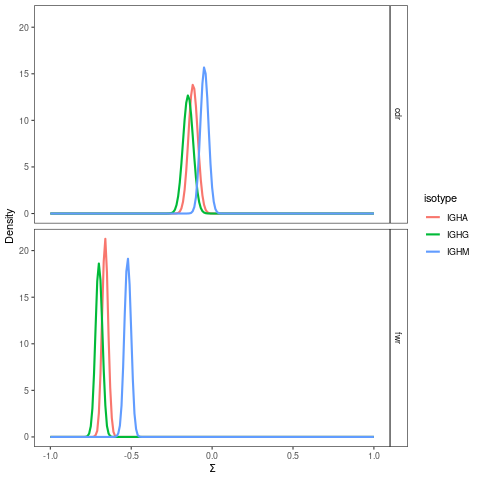

In [40]:
%%R
# Calculate clonal consensus and selection using the BASELINe method
z <- collapseClones(db)
b <- calcBaseline(z, regionDefinition=IMGT_V)
# Combine selection scores for all clones in each group
g <- groupBaseline(b, groupBy="isotype")
# Plot probability densities for the selection pressure
plot(g, "isotype", sigmaLimits=c(-1, 1), silent=F)

# SHazaM: Built in mutation models

`shazam` comes with serveral pre-built targeting models, mutation models and sequence region definitions. They can be used to change the default behaviour of many functions. For example, mutations are usually defined as R when they introduce any change in the amino acid sequence (`NULL`). However, for some analyses, it may be useful to consider some amino acid substitutions to be equivalent (i.e., treated as silent mutations). For example, it is possible to define replacement mutations as only those that introduce a change in the amino acid side chain charge (`CHARGE_MUTATIONS`).

Empirical SHM Targeting Models

- HH_S5F: Human heavy chain 5-mer model

- HKL_S5F: Human light chain 5-mer model

- MK_RS5NF: Mouse light chain 5-mer model

Mutation Definitions

- NULL: Any mutation that results in an amino acid substitution is considered a replacement (R) mutation.

- CHARGE_MUTATIONS:  Only mutations that alter side chain charge are replacements.

- HYDOPATHY_MUTATIONS: Only mutations that alter hydrophobicity class are replacements.

- POLARITY_MUTATIONS: Only mutations that alter polarity are replacements.

- VOLUME_MUTATIONS: Only mutations that alter volume class are replacements.

Sequence Region Definitions

- NULL:  Full sequence

- IMGT_V:  V segment broken into combined CDRs and FWRs

- IMGT_V_BY_REGIONS: V segment broken into individual CDRs and FWRs


# References

Gadala-Maria,D. et al. (2019) Identification of subject-specific
immunoglobulin alleles from expressed repertoire sequencing data. Frontiers
in Immunology, 10, 129.

Gadala-Maria,D. et al. (2015) Automated analysis of high-throughput b-cell
sequencing data reveals a high frequency of novel immunoglobulin v gene
segment alleles. Proceedings of the National Academy of Sciences,
201417683.

Gupta,N.T. et al. (2017) Hierarchical clustering can identify b cell clones
with high confidence in ig repertoire sequencing data. The Journal of
Immunology, 1601850.

Gupta,N.T. et al. (2015) Change-o: A toolkit for analyzing large-scale b cell
immunoglobulin repertoire sequencing data. Bioinformatics, 31, 3356–3358.

Hoehn, K. B. et al. (2019) Repertoire-wide phylogenetic models of B cell molecular evolution reveal evolutionary signatures of aging and vaccination. PNAS 201906020.

Laserson,U. et al. (2014) High-resolution antibody dynamics of
vaccine-induced immune responses. Proc. Natl. Acad. Sci. U.S.A., 111,
4928–4933.

Nouri,N. and Kleinstein,S.H. (2018a) A spectral clustering-based method
for identifying clones from high-throughput b cell repertoire sequencing data.
Bioinformatics, 34, i341–i349.

Nouri,N. and Kleinstein,S.H. (2018b) Optimized threshold inference for
partitioning of clones from high-throughput b cell repertoire sequencing
data. Frontiers in immunology, 9.

Stern,J.N. et al. (2014) B cells populating the multiple sclerosis brain
mature in the draining cervical lymph nodes. Science translational medicine,
6, 248ra107–248ra107.

Vander Heiden,J.A. et al. (2017) Dysregulation of b cell repertoire
formation in myasthenia gravis patients revealed through deep sequencing.
The Journal of Immunology, 1601415.

Yaari,G. et al. (2012) Quantifying selection in high-throughput
immunoglobulin sequencing data sets. Nucleic acids research, 40,
e134–e134.

Yaari,G. et al. (2013) Models of somatic hypermutation targeting and
substitution based on synonymous mutations from high-throughput
immunoglobulin sequencing data. Frontiers in immunology, 4, 358.
